In [1]:
# Project to detect pneumonia from chest X-ray images

In [2]:
import numpy as np
import os
from PIL import Image
import glob
import imageio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [3]:
# The dataset for this project contains chest x-ray images.
# The dataset contains a training folder (5216 images), validation folder (16 images) and test folder (624 images)
# The split of training and validation data here is a bit lopsided so training and validation sets will be adjusted
# These images are greyscale so will be represented by a [pixel_height, pixel width] matrix
# Some images, although being greyscale images, are in a RGB format so will have to be converted
# The images are for patients with bacterial pneumonia, viral pneumonia and no pneumonia
# To increase the amount of data, data augmentation will be used
# This project will use a convolutional neural network to categorise these images
# The CNN will be based on LeNet, with some adjustments
# An example of the x-rays in the dataset is shown below

In [4]:
dir_path = os.path.dirname(os.path.realpath("__file__"))
xray_folder = dir_path + "/chest_xray"

In [5]:
example = xray_folder + "/test/NORMAL/IM-0001-0001.jpeg"

In [6]:
image = Image.open(example)

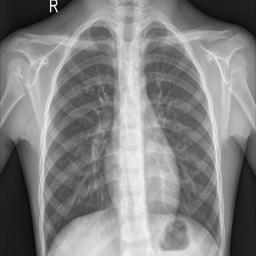

In [7]:
image

In [8]:
# FUNCTIONS FOR PREPROCESSING

In [9]:
# image_to_matrix is a function that converts a jpeg image to a matrix

In [10]:
def image_to_matrix(image):
    # resize image (imagenet used 256 X 256)
    image = image.resize((256, 256))
    matrix = np.zeros([image.height, image.width])
    image_data = image.getdata()
    image_data_list = list(image_data)
    # for all items in list 
    total_pixels = len(image_data_list)
    for x in range(total_pixels):
        width = x % image.width
        height = int(x / image.width)
        # some images are in RGB format (a, b, c) so just take first element  
        if image.mode == 'L':
            matrix[height, width] = image_data_list[x]
        else:
            matrix[height, width] = image_data_list[x][0]
    return matrix.astype(np.uint8)

In [11]:
# matrix_to_image is a function that converts matrix to a jpeg image 

In [12]:
def matrix_to_image(matrix):
    image = Image.fromarray(matrix)
    return image

In [13]:
# create x_train, y_train, x_dev, y_dev, x_test, y_test

In [14]:
test_folder = xray_folder + "/test"
train_folder = xray_folder + "/train"
val_folder = xray_folder + "/val"
test_normal = test_folder + "/NORMAL"
test_pneumonia = test_folder + "/PNEUMONIA"
train_normal = train_folder + "/NORMAL"
train_pneumonia = train_folder + "/PNEUMONIA"
val_normal = val_folder + "/NORMAL"
val_pneumonia = val_folder + "/PNEUMONIA"

In [15]:
image_folders = [test_normal, test_pneumonia, train_normal, train_pneumonia, val_normal, val_pneumonia]

In [16]:
# function to convert RGB images to greyscale images

In [17]:
def RGBtoL(image, filename):
    if image.mode == "RGB":
        image = image.convert("L")
        image.save(filename)

In [18]:
# function to resize images so all images in dataset are the same dimensions

In [19]:
def resize_image(image, filename):
    image = image.resize((256, 256))
    image.save(filename)

In [20]:
# function to apply preprocessing to all images in dataset

In [21]:
def process_data(image_folders):
    for image_folder in image_folders:
        filenames = image_folder + "/*.jpeg"
        for filename in glob.glob(filenames):
            image = Image.open(filename)
            RGBtoL(image, filename)
        for filename in glob.glob(filenames):
            image = Image.open(filename)
            resize_image(image, filename)

In [22]:
# populate a list of images and their categories. pass test, val, or train as a value

In [23]:
def populate_list(dataset, xray_folder):
    if dataset != "test" and dataset != "train" and dataset != "val":
        return "Parameter should be test, train or val"
        
    image_list = []
    normal_filename = xray_folder + "/" + dataset + "/NORMAL/*.jpeg"
    pneumonia_filename = xray_folder + "/" + dataset + "/PNEUMONIA/*.jpeg"
    for filename in glob.glob(normal_filename): 
        image_list.append([filename, 0])
    for filename in glob.glob(pneumonia_filename): 
        if "virus" in filename:
            image_list.append([filename, 1])
        elif "bacteria" in filename:
            image_list.append([filename, 2])
        else:
            image_list.append([filename, -1])
    return image_list

In [24]:
# create_data will take a list of images and categories and will return a populated array of inputs and outputs

In [25]:
def create_data(image_list):
    x = np.zeros([len(image_list), 256 , 256])
    y = np.zeros([len(image_list)])
    for i in range(len(image_list)):
        image = imageio.imread(image_list[i][0])
        x[i] = image
        y[i] = image_list[i][1]
    return x, y

In [26]:
# PREPROCESSING OF DATA

In [27]:
# apply preprocessing to all images

In [28]:
process_data(image_folders)

In [29]:
# create training, validation and test datasets

In [30]:
train_list = populate_list("train", xray_folder)
val_list = populate_list("val", xray_folder)
test_list = populate_list("test", xray_folder)

In [31]:
# split the datasets into inputs and categories 

In [32]:
x_train, y_train = create_data(train_list)

In [33]:
x_val, y_val = create_data(val_list)

In [34]:
x_test, y_test = create_data(test_list)

In [35]:
# X-RAY EXAMPLES

In [36]:
# example of an image from the test set and its label with bacterial pneumonia
# bacterial pneumonia is represented by a label of 2

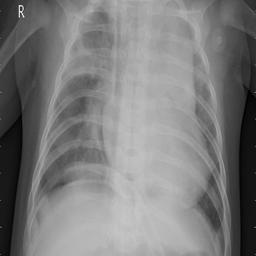

In [37]:
matrix_to_image(x_test[250].astype(np.uint8))

In [38]:
y_test[250]

2.0

In [39]:
# example of an image from the test set and its label with no pneumonia
# no pneumonia is represented by a label of 0

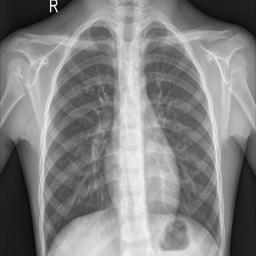

In [40]:
matrix_to_image(x_test[0].astype(np.uint8))

In [41]:
y_test[0]

0.0

In [42]:
# example of an image from the test set and its label with viral pneumonia
# viral pneumonia is represented by a label of 1

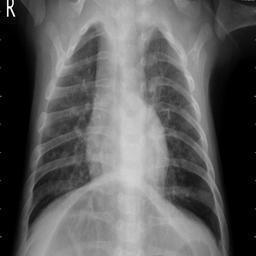

In [43]:
matrix_to_image(x_test[450].astype(np.uint8))

In [44]:
y_test[450]

1.0

In [45]:
# FURTHER DATA PREPROCESSING

In [46]:
# conv2d expects 3d images but I have grayscale images.
# therefore i will reshape input data to be the correct dimension

In [47]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

In [48]:
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [49]:
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)

In [50]:
x_train.shape

(5216, 256, 256, 1)

In [51]:
x_val.shape

(16, 256, 256, 1)

In [52]:
x_test.shape

(624, 256, 256, 1)

In [53]:
# The ratio of training to validation data in the given dataset is skewed heavily towards training data
# This ratio will be adjusted

In [54]:
x_train_val = np.concatenate((x_train, x_val), axis=0)

In [55]:
y_train_val = np.concatenate((y_train, y_val), axis=0)

In [56]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.11, random_state=1)

In [57]:
x_train.shape

(4656, 256, 256, 1)

In [58]:
x_val.shape

(576, 256, 256, 1)

In [59]:
# The data split is now approx 0.8 training, 0.1 validation , 0.1 test  

In [60]:
# DATA AUGMENTATION - I have commented out this section. I was having performance issues with this but ideally I would have included this

In [61]:
# to increase the amount of data, data augmentation is used on the training data

In [62]:
# The first step to this is cropping
# I have randomly cropped all images and resized them to the original dimensions

In [63]:
# x_train_crop = tf.image.random_crop(x_train, [4656, 230, 230, 1], seed=1).numpy()

In [64]:
# x_train_crop_256 = tf.image.resize_with_pad(x_train_crop, 256, 256).numpy()

In [65]:
# x_train_crop_256.shape

In [66]:
# The second step of data augmentation flipping
# All images will be flipped horizontally

In [67]:
# x_train_flip = tf.image.flip_left_right(x_train).numpy()

In [68]:
# The original training data, cropped training data, and flipped training data are combined 

In [69]:
# x_train_augmented = np.concatenate((x_train, x_train_crop_256, x_train_flip))

In [70]:
# y_train_augemented = np.concatenate((y_train, y_train, y_train))

In [71]:
# FUNCTIONS FOR TENSORFLOW

In [72]:
# The model used in this project is inspired by LeNet image classification
# The model used here has some differences in the size of the layers
# It differs from LeNet by using:
    # same convolutions to maintain the size of images
    # max pooling layers instead of average pooling, which is more popular in modern deep learning

In [73]:
# Function that creates and returns the model
# The model will initialize weights with Xavier initialization
# The layers of the model are as follows:
    # a rescaling layer - this is used to normalize the inputs to the model
    # a convolution layer - image detectionf
    # a pooling layer - reducing the size of the representation to increase computation speed
    # a convolution layer
    # a pooling layer 
    # a flatten layer - resizes data to 1d
    # a relu layer - activation function
    # a relu layer
    # a softmax layer - for categorization

In [74]:
def forward_propagation():   
    num_classes = 3
    glorot = tf.keras.initializers.GlorotNormal(seed=1)
    
    model = models.Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 1))),
    model.add(layers.Conv2D(6, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=glorot))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(16, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=glorot))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [75]:
# I also experimented with dropout - randomly setting some input weights to 0
# This is done to improved computational speed and reduce overfitting

In [76]:
# Creates a model similar to the model in foraward_propagation() but with 0.1 dropout layers added

In [77]:
def forward_propagation_with_dropout_1():   
    num_classes = 3
    glorot = tf.keras.initializers.GlorotNormal(seed=1)
    
    model = models.Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 1)))
    model.add(layers.Dropout(0.1, seed=1))
    model.add(layers.Conv2D(6, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=glorot))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.1, seed=1))
    model.add(layers.Conv2D(16, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=glorot))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [78]:
# Creates a model similar to the model in foraward_propagation() but with 0.5 dropout layers added

In [79]:
def forward_propagation_with_dropout_5():   
    num_classes = 3
    glorot = tf.keras.initializers.GlorotNormal(seed=1)
    
    model = models.Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 1)))
    model.add(layers.Dropout(0.5, seed=1))
    model.add(layers.Conv2D(6, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=glorot))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.5, seed=1))
    model.add(layers.Conv2D(16, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer=glorot))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [80]:
# function to evaluate the CNN

In [81]:
def evaluate_model(model, history, X, Y):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc = model.evaluate(X, Y, verbose=2)
    print(test_acc)

In [82]:
# CREATE AND EVALUATE THE MODELS

In [83]:
# define training rate, training rate decay and number of iterations 

In [146]:
training_rate = 0.001
decay_rate = 0.96
epochs = 10
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.compat.v1.train.exponential_decay(training_rate, global_step, epochs, decay_rate, staircase=True)

In [147]:
model = forward_propagation()

In [148]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [149]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_12 (Rescaling)     (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 256, 256, 6)       156       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 128, 128, 6)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 16)      2416      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 120)             

In [150]:
history = model.fit(x_train, y_train, epochs=epochs, 
                    validation_data=(x_val, y_val))

Epoch 1/10
146/146 [==============================] - 87s 595ms/step - loss: 0.8527 - accuracy: 0.6931 - val_loss: 0.7747 - val_accuracy: 0.7760
Epoch 2/10
146/146 [==============================] - 87s 596ms/step - loss: 0.7766 - accuracy: 0.7721 - val_loss: 0.7647 - val_accuracy: 0.7812
Epoch 3/10
146/146 [==============================] - 88s 603ms/step - loss: 0.7585 - accuracy: 0.7904 - val_loss: 0.7625 - val_accuracy: 0.7812
Epoch 4/10
146/146 [==============================] - 89s 607ms/step - loss: 0.7443 - accuracy: 0.8033 - val_loss: 0.7653 - val_accuracy: 0.7812
Epoch 5/10
146/146 [==============================] - 92s 631ms/step - loss: 0.7441 - accuracy: 0.8043 - val_loss: 0.7492 - val_accuracy: 0.8021
Epoch 6/10
146/146 [==============================] - 91s 623ms/step - loss: 0.7304 - accuracy: 0.8198 - val_loss: 0.7527 - val_accuracy: 0.7899
Epoch 7/10
146/146 [==============================] - 87s 594ms/step - loss: 0.7261 - accuracy: 0.8226 - val_loss: 0.7447 - val_ac

20/20 - 3s - loss: 0.8955 - accuracy: 0.6458
0.6458333134651184


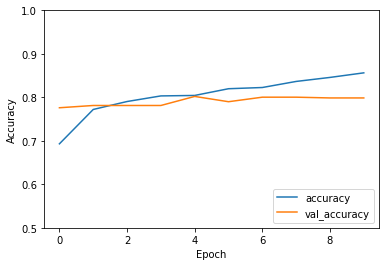

In [151]:
evaluate_model(model, history, x_test, y_test)

In [152]:
model1 = forward_propagation_with_dropout_1()

In [153]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [154]:
model1.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_13 (Rescaling)     (None, 256, 256, 1)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 256, 256, 6)       156       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 128, 128, 6)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 128, 6)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 16)      2416      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 64, 64, 16)      

In [155]:
history1 = model1.fit(x_train, y_train, epochs=epochs, 
                    validation_data=(x_val, y_val))

Epoch 1/10
146/146 [==============================] - 95s 653ms/step - loss: 0.9536 - accuracy: 0.5934 - val_loss: 0.8379 - val_accuracy: 0.7188
Epoch 2/10
146/146 [==============================] - 95s 648ms/step - loss: 0.7806 - accuracy: 0.7650 - val_loss: 0.8125 - val_accuracy: 0.7396
Epoch 3/10
146/146 [==============================] - 95s 651ms/step - loss: 0.7589 - accuracy: 0.7897 - val_loss: 0.7858 - val_accuracy: 0.7639
Epoch 4/10
146/146 [==============================] - 97s 664ms/step - loss: 0.7556 - accuracy: 0.7912 - val_loss: 0.7727 - val_accuracy: 0.7778
Epoch 5/10
146/146 [==============================] - 97s 664ms/step - loss: 0.7483 - accuracy: 0.7977 - val_loss: 0.7899 - val_accuracy: 0.7535
Epoch 6/10
146/146 [==============================] - 95s 653ms/step - loss: 0.7345 - accuracy: 0.8155 - val_loss: 0.7648 - val_accuracy: 0.7847
Epoch 7/10
146/146 [==============================] - 95s 654ms/step - loss: 0.7232 - accuracy: 0.8237 - val_loss: 0.7910 - val_ac

20/20 - 3s - loss: 0.9008 - accuracy: 0.6362
0.6362179517745972


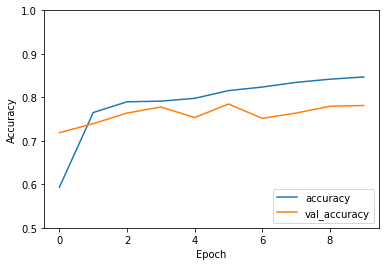

In [156]:
evaluate_model(model1, history1, x_test, y_test)

In [157]:
model2 = forward_propagation_with_dropout_5()

In [158]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [159]:
model2.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_14 (Rescaling)     (None, 256, 256, 1)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 256, 256, 6)       156       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 128, 128, 6)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 128, 6)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 128, 128, 16)      2416      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 64, 64, 16)      

In [160]:
history2 = model2.fit(x_train, y_train, epochs=epochs, 
                    validation_data=(x_val, y_val))

Epoch 1/10
146/146 [==============================] - 95s 651ms/step - loss: 1.0683 - accuracy: 0.4815 - val_loss: 1.0480 - val_accuracy: 0.5035
Epoch 2/10
146/146 [==============================] - 94s 642ms/step - loss: 1.0686 - accuracy: 0.4828 - val_loss: 1.0480 - val_accuracy: 0.5035
Epoch 3/10
146/146 [==============================] - 97s 663ms/step - loss: 1.0686 - accuracy: 0.4828 - val_loss: 1.0480 - val_accuracy: 0.5035
Epoch 4/10
146/146 [==============================] - 99s 677ms/step - loss: 1.0686 - accuracy: 0.4828 - val_loss: 1.0480 - val_accuracy: 0.5035
Epoch 5/10
146/146 [==============================] - 96s 657ms/step - loss: 1.0686 - accuracy: 0.4828 - val_loss: 1.0480 - val_accuracy: 0.5035
Epoch 6/10
146/146 [==============================] - 95s 651ms/step - loss: 1.0686 - accuracy: 0.4828 - val_loss: 1.0480 - val_accuracy: 0.5035
Epoch 7/10
146/146 [==============================] - 94s 642ms/step - loss: 1.0686 - accuracy: 0.4828 - val_loss: 1.0480 - val_ac

20/20 - 3s - loss: 1.1636 - accuracy: 0.3878
0.3878205120563507


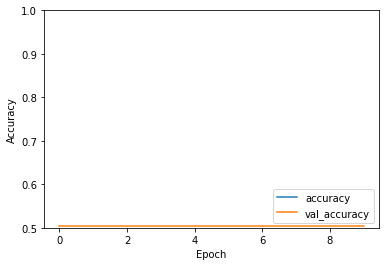

In [161]:
evaluate_model(model2, history2, x_test, y_test)

In [ ]:
'''
I ran three CNN models to categorise pneumonia x-rays, each with different levels of drop out
The most successful model was the first model, which contained no dropout
This model predicted pneumonia at 65% accuracy on the test data.
The model had 86% accuracy on the test set and 80% on validation set
This would suggest that the model is overfitted on this data as the values are higher than the test set

I also ran into issues with the the accuracy not changing between epoch (as seen in the third model)
This is likely due to the optimizer finding an undesirable local minimum
To prevent this happening in all models I had to use a small learning rate, which may have affected overall performance

To improve this project, I could try different optimization functions and optimizers to avoid the local minimum issue
This would also allow me to increase the learning rate and improve results
'''